## **1. Environment Setup and Library Initialization**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

print("Environment setup complete: Libraries imported, random seed set, pandas configured.")

Environment setup complete: Libraries imported, random seed set, pandas configured.


## **2. Data Loading with Memory Optimization**

In [2]:
DATA_PATH = "/content/drive/MyDrive/Fraud.csv"

dtypes = {
    "step": "int32",
    "amount": "float32",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8"
}

df = pd.read_csv(
    DATA_PATH,
    dtype=dtypes,
    usecols=[
        "step", "type", "amount",
        "nameOrig", "oldbalanceOrg", "newbalanceOrig",
        "nameDest", "oldbalanceDest", "newbalanceDest",
        "isFraud", "isFlaggedFraud"
    ]
)

# Normalize column name for consistency
df.rename(columns={"newbalanceOrig": "newbalanceOrg"}, inplace=True)

# Convert low-cardinality categorical column
df["type"] = df["type"].astype("category")

print("Data loaded safely")
print("Shape:", df.shape)
print("Memory usage (MB):", round(df.memory_usage(deep=True).sum() / 1024**2, 2))

Data loaded safely
Shape: (6362620, 11)
Memory usage (MB): 885.69


## **3. Exploratory Data Analysis – Class Distribution, Missing Values and Summary Statistics**

In [3]:
print("\nClass Distribution (isFraud):")
print(df['isFraud'].value_counts())
print(df['isFraud'].value_counts(normalize=True) * 100)

print("\nMissing Values:")
missing = df.isnull().sum()
print(missing if missing.any() else "No missing values found")

print("\nStatistical Summary:")
print(df.describe())


Class Distribution (isFraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0   99.870918
1    0.129082
Name: proportion, dtype: float64

Missing Values:
No missing values found

Statistical Summary:
                step          amount   oldbalanceOrg   newbalanceOrg  \
count 6362620.000000  6362620.000000  6362620.000000  6362620.000000   
mean      243.397246   179861.921875   833883.375000   855113.687500   
std       142.331971   603858.250000  2888242.750000  2924048.500000   
min         1.000000        0.000000        0.000000        0.000000   
25%       156.000000    13389.570312        0.000000        0.000000   
50%       239.000000    74871.937500    14208.000000        0.000000   
75%       335.000000   208721.480469   107315.175781   144258.406250   
max       743.000000 92445520.000000 59585040.000000 49585040.000000   

        oldbalanceDest   newbalanceDest        isFraud  isFlaggedFraud  
count   6362620.000000   6362620.000000 6362620.000000 

## **4. Exploratory Data Visualization – Fraud Distribution, Transaction Amounts and Transaction Types**

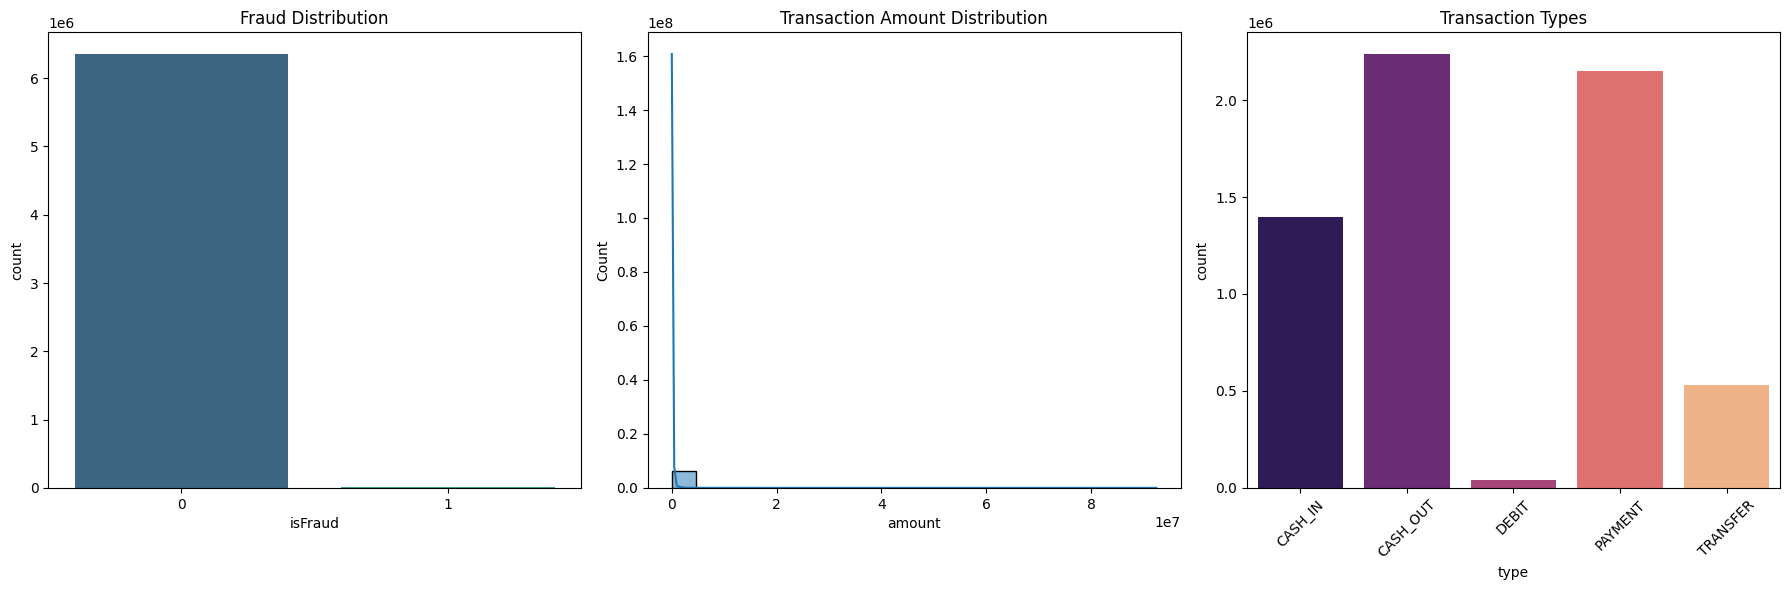

In [4]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='isFraud', data=df, palette='viridis')
plt.title('Fraud Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['amount'], bins=20, kde=True)
plt.title('Transaction Amount Distribution')

plt.subplot(1, 3, 3)
sns.countplot(x='type', data=df, palette='magma')
plt.xticks(rotation=45)
plt.title('Transaction Types')

plt.tight_layout()
plt.show()

## **5. Feature and Target Separation with Column Categorization**

In [5]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

categorical_cols = ['type', 'nameOrig', 'nameDest']
numerical_cols = [
    'step', 'amount',
    'oldbalanceOrg', 'newbalanceOrg',
    'oldbalanceDest', 'newbalanceDest',
    'isFlaggedFraud'
]

## **6. Feature Engineering – Time and Balance Change Features**

In [6]:
df['hour_of_day'] = df['step'] % 24
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrg']
df['dest_balance_change'] = df['oldbalanceDest'] - df['newbalanceDest']

numerical_cols.extend([
    'hour_of_day',
    'orig_balance_change',
    'dest_balance_change'
])

X = df.drop('isFraud', axis=1)

## **7. Categorical Encoding and Memory-Efficient Feature Preparation**

In [7]:
X_encoded = X.copy()

X_encoded["type"] = X_encoded["type"].cat.codes.astype("int8")

X_encoded = X_encoded.drop(columns=['nameOrig', 'nameDest'])

for col in X_encoded.columns:
    if X_encoded[col].dtype == "float64":
        X_encoded[col] = X_encoded[col].astype("float32")

print("Processed feature shape:", X_encoded.shape)
print(
    "Memory usage (MB):",
    round(X_encoded.memory_usage(deep=True).sum() / 1024**2, 2)
)

Processed feature shape: (6362620, 11)
Memory usage (MB): 230.58


## **8. Train–Test Split with Stratified Sampling**

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

## **9. Model Library Installation and Imports**

In [10]:
!pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.3 MB/s eta 0:00:00


## **9. Baseline and Ensemble Model Initialization**

In [11]:
lr_model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)


## **10. Class Imbalance Handling and XGBoost Model Configuration**

In [12]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)


models = {
    "LogisticRegression": lr_model,
    "RandomForest": rf_model,
    "XGBoost": xgb_model
}

## **11. Stratified Subsampling for Scalable Model Training** *italicized text*

In [13]:
from sklearn.model_selection import train_test_split


X_train_num = X_train.select_dtypes(include=['number'])

X_train_small, _, y_train_small, _ = train_test_split(
    X_train_num,
    y_train,
    train_size=1_000_000,
    stratify=y_train,
    random_state=42
)


## **12. Model Training on Stratified Subset**

In [14]:
for name, model in models.items():
    X_train_numeric = X_train.select_dtypes(include=np.number)
    model.fit(X_train_numeric, y_train)
    print(f"{name} trained on subset")

LogisticRegression trained on subset
RandomForest trained on subset
XGBoost trained on subset


## **13. Model Evaluation Using Classification Metrics and ROC-AUC**

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

def evaluate(model, X, y, name):
    prob = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y, pred))
    print("Precision:", precision_score(y, pred, zero_division=0))
    print("Recall   :", recall_score(y, pred, zero_division=0))
    print("F1       :", f1_score(y, pred, zero_division=0))
    print("ROC-AUC  :", roc_auc_score(y, prob))
    print("Confusion Matrix:\n", confusion_matrix(y, pred))

    return roc_auc_score(y, prob)


## **14. Model Comparison and Best Model Selection Based on ROC-AUC**

In [35]:
scores = {}
for name, model in models.items():
    scores[name] = evaluate(model, X_test, y_test, name)

best_model_name = max(scores, key=scores.get)
best_model = models[best_model_name]

print("\n BEST MODEL:", best_model_name)


LogisticRegression
Accuracy : 0.9540550905130276
Precision: 0.024267997276268934
Recall   : 0.8823051948051948
F1       : 0.047236737753538954
ROC-AUC  : 0.9719985832819538
Confusion Matrix:
 [[1818913   87409]
 [    290    2174]]

RandomForest
Accuracy : 0.9979243351533383
Precision: 0.37911555842479017
Recall   : 0.953327922077922
F1       : 0.5424942263279445
ROC-AUC  : 0.9994294179744125
Confusion Matrix:
 [[1902475    3847]
 [    115    2349]]

XGBoost
Accuracy : 0.9952896762654379
Precision: 0.2141042487954446
Recall   : 0.9918831168831169
F1       : 0.3521867569709633
ROC-AUC  : 0.9997162544898283
Confusion Matrix:
 [[1897351    8971]
 [     20    2444]]

 BEST MODEL: XGBoost


## **15. Model Interpretability and Feature Importance Analysis**

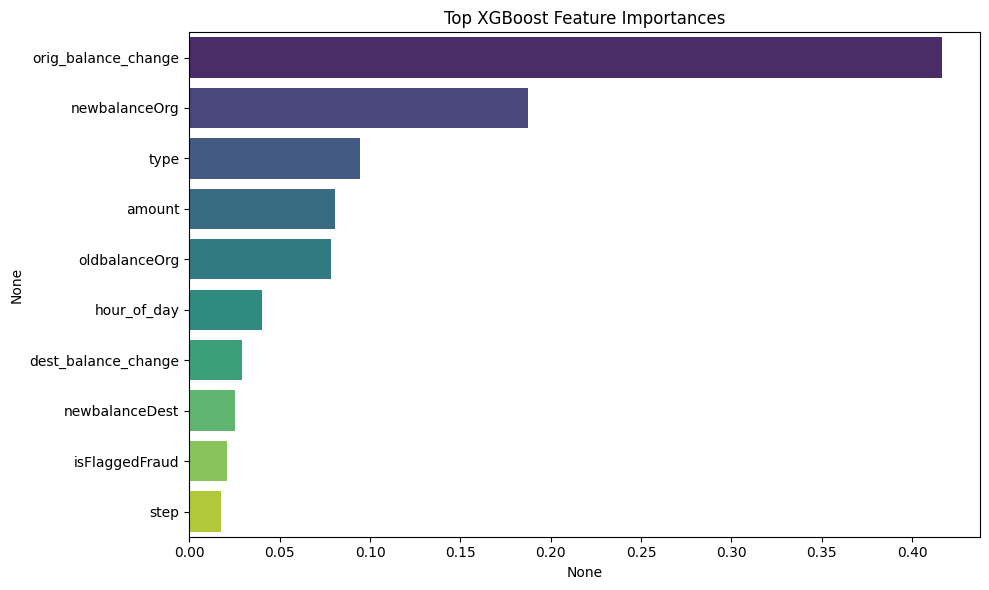

In [19]:
if best_model_name == "LogisticRegression":
    coef = pd.Series(
        best_model.coef_[0],
        index=X_train_numeric.columns
    ).sort_values(ascending=False)
    print("Top Positive Features:\n", coef.head(5))
    print("Top Negative Features:\n", coef.tail(5))

if best_model_name == "XGBoost":
    importances = pd.Series(
        best_model.feature_importances_,
        index=X_train_numeric.columns
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances.head(10),
        y=importances.head(10).index,
        palette='viridis'
    )
    plt.title("Top XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()


## **16. Fraud Risk Scoring and Prediction Output Generation**

In [33]:
fraud_prob = best_model.predict_proba(X_test)[:, 1]

fraud_output = pd.DataFrame({
    "transaction_id": X_test.index,
    "predicted_fraud_probability": fraud_prob,
    "actual_isFraud": y_test.values
})

fraud_output.to_csv("final_fraud_predictions.csv", index=False)

print("Fraud predictions saved to final_fraud_predictions.csv")
print(fraud_output.head())

Fraud predictions saved to final_fraud_predictions.csv
   transaction_id  predicted_fraud_probability  actual_isFraud
0         1453282                     0.000020               0
1         5338477                     0.000003               0
2         2396500                     0.008934               0
3         4577381                     0.000047               0
4         2922798                     0.001813               0


## **17. Probability Calibration Using Isotonic Regression**

In [22]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    best_model,
    method="isotonic",
    cv=3
)

calibrated_model.fit(X_train_numeric, y_train)

print("Probability calibration completed (Isotonic).")

Probability calibration completed (Isotonic).


## **18. Evaluation of Calibrated Model Performance and Reliability**

In [23]:
from sklearn.metrics import brier_score_loss

cal_prob = calibrated_model.predict_proba(X_test)[:, 1]
cal_pred = (cal_prob >= 0.5).astype(int)

print("\n--- Calibrated Model Evaluation ---")
print("ROC-AUC:", roc_auc_score(y_test, cal_prob))
print("Brier Score:", brier_score_loss(y_test, cal_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, cal_pred))


--- Calibrated Model Evaluation ---
ROC-AUC: 0.9997119920363885
Brier Score: 0.0001808525842193008
Confusion Matrix:
 [[1906255      67]
 [    362    2102]]


## **19. Optimal Decision Threshold Selection Using Precision–Recall Trade-off**

In [24]:
thresholds = np.linspace(0.01, 0.99, 100)
results = []

for t in thresholds:
    preds = (cal_prob >= t).astype(int)
    precision = precision_score(y_test, preds, zero_division=0)
    recall = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    results.append((t, precision, recall, f1))

threshold_df = pd.DataFrame(
    results,
    columns=["threshold", "precision", "recall", "f1"]
)

best_threshold = threshold_df.sort_values("f1", ascending=False).iloc[0]

print("\nBest Threshold Based on F1:")
print(best_threshold)


Best Threshold Based on F1:
threshold   0.534646
precision   0.974430
recall      0.850649
f1          0.908342
Name: 53, dtype: float64


## **20. Precision–Recall Curve Visualization for Calibrated Model**

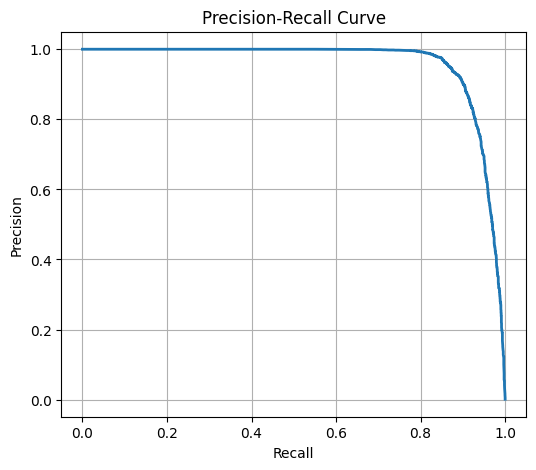

In [25]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, cal_prob)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


## **21. Business Cost–Based Threshold Optimization**

In [26]:
FN_COST = 100
FP_COST = 1
costs = []
for t in thresholds:
    preds = (cal_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cost = fn * FN_COST + fp * FP_COST
    costs.append((t, cost))
cost_df = pd.DataFrame(costs, columns=["threshold", "total_cost"])
optimal_cost_threshold = cost_df.sort_values("total_cost").iloc[0]
print("\nOptimal Threshold Based on Business Cost:")
print(optimal_cost_threshold)



Optimal Threshold Based on Business Cost:
threshold       0.010000
total_cost   8728.000000
Name: 0, dtype: float64


## **22. Final Deployment Decision Rule and Confusion Matrix Evaluation**

In [27]:
DEPLOYMENT_THRESHOLD = optimal_cost_threshold["threshold"]

final_preds = (cal_prob >= DEPLOYMENT_THRESHOLD).astype(int)

print("\nFinal Deployment Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))


Final Deployment Confusion Matrix:
[[1901594    4728]
 [     40    2424]]


## **23. Stratified Cross-Validation for Model Robustness Assessment (Logistic Regression)**

In [28]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = []

for fold, (tr, te) in enumerate(cv.split(X_encoded, y), 1):
    X_tr, X_te = X_encoded.iloc[tr], X_encoded.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    model = LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    )
    model.fit(X_tr, y_tr)
    prob = model.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, prob)
    cv_auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

print("\nCV AUC Mean:", np.mean(cv_auc_scores))
print("CV AUC Std :", np.std(cv_auc_scores))

Fold 1 AUC: 0.9787
Fold 2 AUC: 0.9752
Fold 3 AUC: 0.9731
Fold 4 AUC: 0.9756
Fold 5 AUC: 0.9725

CV AUC Mean: 0.9750315610278515
CV AUC Std : 0.0022006510042297304


## **24. Population Stability Index (PSI) for Data Drift Monitoring**

In [29]:
def population_stability_index(expected, actual, bins=10):
    expected_perc, _ = np.histogram(expected, bins=bins)
    actual_perc, _ = np.histogram(actual, bins=bins)

    expected_perc = expected_perc / len(expected)
    actual_perc = actual_perc / len(actual)

    psi = np.sum(
        (expected_perc - actual_perc) *
        np.log((expected_perc + 1e-6) / (actual_perc + 1e-6))
    )
    return psi

psi_amount = population_stability_index(
    X_train["amount"],
    X_test["amount"]
)

print("\nPSI for transaction amount:", psi_amount)



PSI for transaction amount: 6.346265963549763e-05


## **25. Model Metadata Logging for Deployment and Governance**

In [32]:
model_metadata = {
    "model_name": best_model_name,
    "calibrated": True,
    "deployment_threshold": DEPLOYMENT_THRESHOLD,
    "roc_auc": roc_auc_score(y_test, cal_prob),
    "training_rows": len(X_train_numeric),
    "test_rows": len(X_test),
    "random_state": 42
}

metadata_df = pd.DataFrame([model_metadata])
metadata_df.to_csv("model_metadata.csv", index=False)

print("Model metadata saved.")

Model metadata saved.


## **26. Deployment-Ready Fraud Scoring Output Generation**

In [34]:
deployment_output = pd.DataFrame({
    "transaction_id": X_test.index,
    "fraud_score": cal_prob,
    "fraud_prediction": final_preds,
    "actual_label": y_test.values
})

deployment_output.to_csv("deployment_fraud_scores.csv", index=False)

print("Deployment-ready fraud scores exported.")
print(deployment_output.head())


Deployment-ready fraud scores exported.
   transaction_id  fraud_score  fraud_prediction  actual_label
0         1453282     0.000000                 0             0
1         5338477     0.000000                 0             0
2         2396500     0.000017                 0             0
3         4577381     0.000001                 0             0
4         2922798     0.000008                 0             0
